In [33]:
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
pd.options.display.max_columns = None
#from sklearn.linear_model import LinearRegression

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt, log

In [35]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

# Import data

In [36]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [37]:
df_train = df_train.rename(columns={'Cabin': 'Cabine', 'Embarked':'PortEmbarquement', 'Fare': 'Tarif', 'Name':'Nom', 'Parch': 'ParentEnfant','Pclass':'Class','SibSp':'FrereSeur', 'Survived':'Survecu'})
df_test = df_test.rename(columns={'Cabin': 'Cabine', 'Embarked':'PortEmbarquement', 'Fare': 'Tarif', 'Name':'Nom', 'Parch': 'ParentEnfant','Pclass':'Class','SibSp':'FrereSeur', 'Survived':'Survecu'})

# Missing Values

In [38]:
# Make a copy to keep data original
train = df_train.copy()
test = df_test.copy()
full_data = [train, test]

In [39]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Cabine,687,0.771044
Age,177,0.198653
PortEmbarquement,2,0.002245
Tarif,0,0.000000
Ticket,0,0.000000
ParentEnfant,0,0.000000
FrereSeur,0,0.000000
Sex,0,0.000000
Nom,0,0.000000
Class,0,0.000000


In [40]:
for dataset in full_data:
    dataset['Tarif'] = dataset['Tarif'].fillna(dataset['Tarif'].median())
    dataset['PortEmbarquement'] = dataset['PortEmbarquement'].fillna('S')
    age =dataset['Age']
    dataset['Age_1'] = age
    dataset['Age_2'] = age

# Feature Engineering

### FamilleTaille et Avoir_Cabine

In [41]:
for dataset in full_data:
    # Famille Taille
    dataset['FamilleTaille'] = dataset['ParentEnfant'] + dataset['FrereSeur'] + 1
    # Avoir_cabine
    dataset['Avoir_Cabine'] = dataset["Cabine"].apply(lambda x: 0 if type(x) == float else 1)
    dataset.loc[(dataset['Class'] != 3), 'Avoir_Cabine'] = 1

# Title

In [42]:
def get_title(name):
    title_search = re.search(' ([A-z]+)\.\s+([A-Za-z]+(\s+[A-Za-z]+)?)', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['title'] = dataset['Nom'].apply(get_title)
    
for dataset in full_data:
    dataset['title'] = dataset['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
    dataset['title'] = dataset['title'].replace('Ms', 'Miss')
    dataset['title'] = dataset['title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['title'] = dataset['title'].map(title_mapping)
    dataset['title'] = dataset['title'].fillna(0)

### Richesse

In [43]:
for dataset in full_data:
    dataset.loc[(dataset['Sex']=='female') & (dataset['Class'] != 3), 'Richesse'] = 1
    #dataset.loc[(dataset['Tarif'] >= 50.) & (dataset['Sex'] == 'male'), 'Richesse'] = 2
    dataset.loc[(dataset['Sex']=='female') & (dataset['Class'] == 3),  'Richesse'] = 2
    dataset.loc[(dataset['Sex']=='male') & (dataset['Class'] != 3), 'Richesse'] = 3
    dataset.loc[(dataset['Sex']=='male') & (dataset['Class'] == 3), 'Richesse'] = 4
    

### ParentEnfant_categorielle

In [44]:
for dataset in full_data:
    dataset.loc[dataset['ParentEnfant']==0, 'ParentEnfant_categorielle'] = 0
    dataset.loc[(dataset['ParentEnfant']==1) | (dataset['ParentEnfant']==2), 'ParentEnfant_categorielle'] = 2
    dataset.loc[(dataset['ParentEnfant']==3) | (dataset['ParentEnfant']==4), 'ParentEnfant_categorielle'] = 4
    dataset.loc[dataset['ParentEnfant']>= 5, 'ParentEnfant_categorielle'] = 6

In [45]:
train = pd.concat([train,pd.get_dummies(train[['Sex', 'PortEmbarquement']])],axis=1)
test = pd.concat([test,pd.get_dummies(test[['Sex', 'PortEmbarquement']])],axis=1)

## Age par mean

In [46]:
full_data = [train, test]

In [47]:
for dataset in full_data:
    age_avg = dataset['Age_2'].mean()
    age_std = dataset['Age_2'].std()
    age_null_count = dataset['Age_2'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age_2'][np.isnan(dataset['Age_2'])] = age_null_random_list
    dataset['Age_2'] = dataset['Age_2'].astype(int)

for dataset in full_data:
    # Age
    dataset.loc[ dataset['Age_2'] <= 15, 'CateriAge'] = 0
    dataset.loc[(dataset['Age_2'] > 15) & (dataset['Age_2'] <= 34), 'CateriAge'] = 1
    dataset.loc[(dataset['Age_2'] > 34) & (dataset['Age_2'] <= 50), 'CateriAge'] = 2
    dataset.loc[(dataset['Age_2'] > 50) & (dataset['Age_2'] <= 64), 'CateriAge'] = 3
    dataset.loc[ dataset['Age_2'] > 64, 'CateriAge'] = 4 ;
   

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Age par Linear Regression

In [48]:
def remplace_missing_values_age(data):
    mask = data['Age_1'] > 0 #(column data avec des values ages manquants )
    train_age = data[mask] 
    test_age = data[~mask]
    
    # on choit des colonnes qu'on veut mettre pour linear regression
    age_train = train_age['Age_1']
    train_colonnes = train_age[['Class', 'Sex_female','Sex_male', 'title', 'Tarif', 'ParentEnfant', 'FrereSeur']]
    test_colonnes = test_age[['Class', 'Sex_female','Sex_male', 'title', 'Tarif', 'ParentEnfant', 'FrereSeur']]
    
    # Regression pour age
    reg = LinearRegression()
    reg.fit(train_colonnes, age_train)
    age_test = reg.predict(test_colonnes)
    age_test[age_test < 0] = 0
    
    # remplacer les values manquants dans la colonne 'Age_1'
    data['Age_1'][mask] = age_train.astype(int)
    data['Age_1'][~mask] = age_test.astype(int)
    
    return data

In [49]:
train = remplace_missing_values_age(train)
test = remplace_missing_values_age(test)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

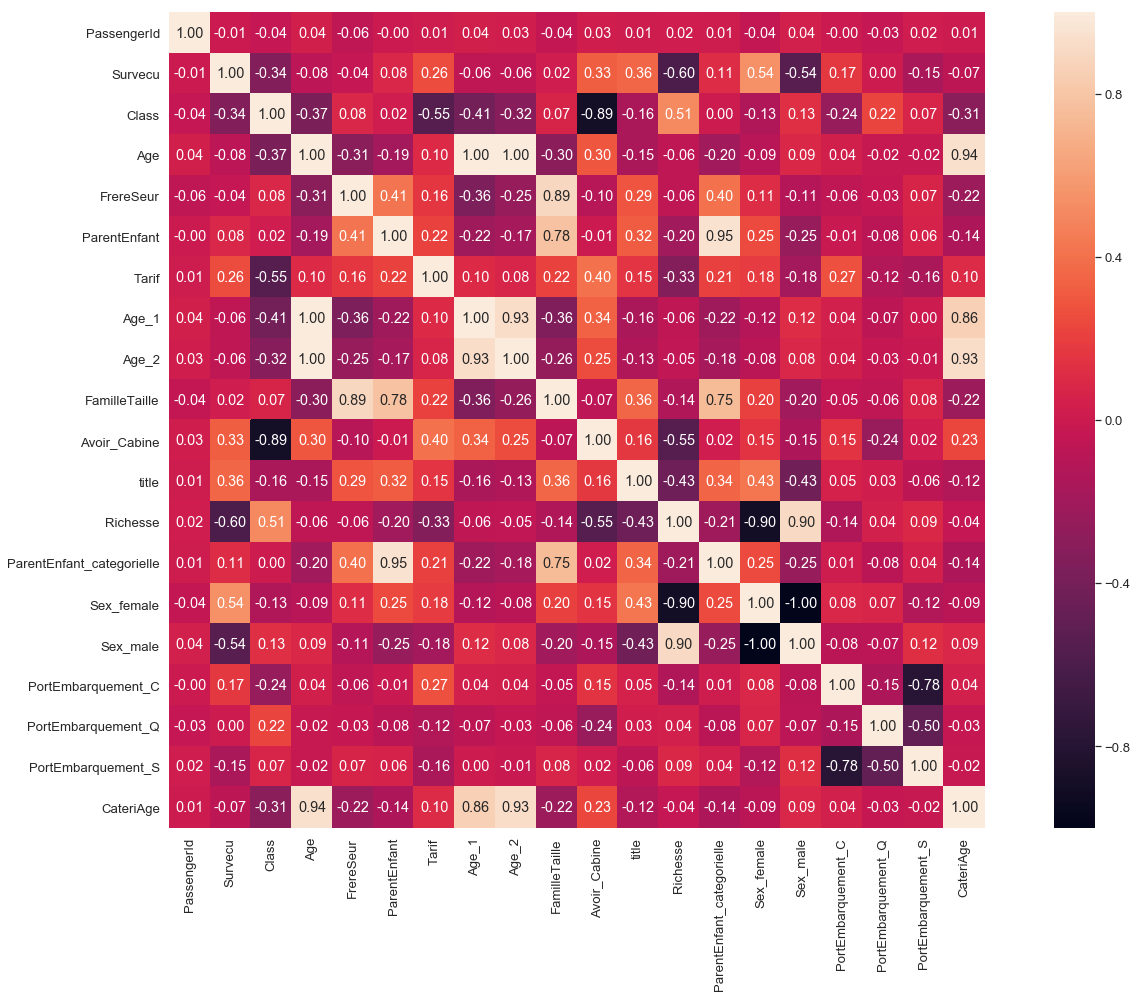

In [50]:
corrmat = train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
sns.set(font_scale=1.2)
sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f')
plt.show()


In [51]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Cabine,687,0.771044
Age,177,0.198653
CateriAge,0,0.000000
PortEmbarquement,0,0.000000
Survecu,0,0.000000
Class,0,0.000000
Nom,0,0.000000
Sex,0,0.000000
FrereSeur,0,0.000000
ParentEnfant,0,0.000000


# Modelling

## Normalise data

In [52]:
train.head()

,PassengerId,Survecu,Class,Nom,Sex,Age,FrereSeur,ParentEnfant,Ticket,Tarif,Cabine,PortEmbarquement,Age_1,Age_2,FamilleTaille,Avoir_Cabine,title,Richesse,ParentEnfant_categorielle,Sex_female,Sex_male,PortEmbarquement_C,PortEmbarquement_Q,PortEmbarquement_S,CateriAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,22,2,0,1.0,4.0,0.0,0,1,0,0,1,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,38,2,1,3.0,1.0,0.0,1,0,1,0,0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,26,1,0,2.0,2.0,0.0,1,0,0,0,1,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,35,2,1,3.0,1.0,0.0,1,0,0,0,1,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,35,1,0,1.0,4.0,0.0,0,1,0,0,1,2.0


In [53]:
train.columns

Index(['PassengerId', 'Survecu', 'Class', 'Nom', 'Sex', 'Age', 'FrereSeur',
       'ParentEnfant', 'Ticket', 'Tarif', 'Cabine', 'PortEmbarquement',
       'Age_1', 'Age_2', 'FamilleTaille', 'Avoir_Cabine', 'title', 'Richesse',
       'ParentEnfant_categorielle', 'Sex_female', 'Sex_male',
       'PortEmbarquement_C', 'PortEmbarquement_Q', 'PortEmbarquement_S',
       'CateriAge'],
      dtype='object')

In [54]:
num_cols = ['Tarif', 'Age_1', 'Age_2']
minmaxScaler = MinMaxScaler()
train[num_cols] = minmaxScaler.fit_transform(train[num_cols])
test[num_cols] = minmaxScaler.fit_transform(test[num_cols])

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [55]:
survecu = train['Survecu']
X_train, X_test, y_train, y_test = train_test_split(train, survecu, random_state = 42)

In [56]:
train.columns

Index(['PassengerId', 'Survecu', 'Class', 'Nom', 'Sex', 'Age', 'FrereSeur',
       'ParentEnfant', 'Ticket', 'Tarif', 'Cabine', 'PortEmbarquement',
       'Age_1', 'Age_2', 'FamilleTaille', 'Avoir_Cabine', 'title', 'Richesse',
       'ParentEnfant_categorielle', 'Sex_female', 'Sex_male',
       'PortEmbarquement_C', 'PortEmbarquement_Q', 'PortEmbarquement_S',
       'CateriAge'],
      dtype='object')

In [57]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, precision_score, recall_score, auc
from matplotlib import pyplot

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import xgboost as xgb

In [86]:
from sklearn import ensemble
# Emsemble method
MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    LogisticRegression(solver = 'lbfgs'),
    SVC(gamma = 0.2),
    tree.DecisionTreeClassifier()
    ]

In [87]:
def compare_model(x_train, x_test, y_train_xx, y_test_xx):
    MLA_columns = []
    MLA_compare = pd.DataFrame(columns = MLA_columns)


    row_index = 0
    for alg in MLA:
        
        predicted = alg.fit(x_train, y_train_xx).predict(x_test)
        fp, tp, th = roc_curve(y_test_xx, predicted)
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index,'ML Name'] = MLA_name
        MLA_compare.loc[row_index, 'ML Train Accuracy'] = round(alg.score(x_train, y_train_xx), 4)
        MLA_compare.loc[row_index, 'ML Test Accuracy'] = round(alg.score(x_test, y_test_xx), 4)
        MLA_compare.loc[row_index, 'ML Precission'] = precision_score(y_test_xx, predicted)
        MLA_compare.loc[row_index, 'ML Recall'] = recall_score(y_test_xx, predicted)
        MLA_compare.loc[row_index, 'ML AUC'] = auc(fp, tp)


        row_index+=1
        
    return (MLA_compare, MLA_columns)
            

In [88]:
X_train_1 = X_train[['Class', 'Sex_female','Sex_male','FamilleTaille', 'title']]
X_test_1 = X_test[['Class', 'Sex_female','Sex_male','FamilleTaille','title']]

In [89]:
(MLA_compare, MLA_columns) = compare_model(X_train_1, X_test_1, y_train, y_test)
MLA_compare.sort_values(by = ['ML Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,ML Name,ML Train Accuracy,ML Test Accuracy,ML Precission,ML Recall,ML AUC
5,SVC,0.8353,0.8341,0.817073,0.752809,0.820434
0,AdaBoostClassifier,0.8263,0.8296,0.814815,0.741573,0.814816
2,GradientBoostingClassifier,0.8428,0.7937,0.752941,0.719101,0.781192
3,RandomForestClassifier,0.8443,0.7892,0.738636,0.730337,0.779348
4,LogisticRegression,0.7979,0.7892,0.750000,0.707865,0.775574
6,DecisionTreeClassifier,0.8443,0.7892,0.738636,0.730337,0.779348
1,ExtraTreesClassifier,0.8443,0.7803,0.732558,0.707865,0.768112


In [90]:
X_train_2 = X_train[['Class', 'Sex_female','Sex_male','FamilleTaille', 'title', 'Age_1']]
X_test_2 = X_test[['Class', 'Sex_female','Sex_male','FamilleTaille','title', 'Age_1']]

In [99]:
MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(n_estimators = 3 ),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_estimators = 3 ),
    LogisticRegression(solver = 'lbfgs'),
    SVC(gamma = 0.2),
    tree.DecisionTreeClassifier()
    ]

In [100]:
(MLA_compare, MLA_columns) = compare_model(X_train_2, X_test_2, y_train, y_test)
MLA_compare.sort_values(by = ['ML Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,ML Name,ML Train Accuracy,ML Test Accuracy,ML Precission,ML Recall,ML AUC
5,SVC,0.8353,0.8341,0.817073,0.752809,0.820434
2,GradientBoostingClassifier,0.8743,0.8117,0.805195,0.696629,0.792344
4,LogisticRegression,0.8159,0.8027,0.777778,0.707865,0.786768
0,AdaBoostClassifier,0.8368,0.7937,0.759036,0.707865,0.779306
1,ExtraTreesClassifier,0.9207,0.7937,0.731183,0.764045,0.788739
3,RandomForestClassifier,0.9042,0.7937,0.717172,0.797753,0.794399
6,DecisionTreeClassifier,0.9207,0.7713,0.706522,0.730337,0.764422


In [92]:
X_train_3 = X_train[['Class', 'Sex_female','Sex_male','FamilleTaille', 'title', 'Age_2']]
X_test_3 = X_test[['Class', 'Sex_female','Sex_male','FamilleTaille','title', 'Age_2']]

In [93]:
(MLA_compare, MLA_columns) = compare_model(X_train_3, X_test_3, y_train, y_test)
MLA_compare.sort_values(by = ['ML Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,ML Name,ML Train Accuracy,ML Test Accuracy,ML Precission,ML Recall,ML AUC
5,SVC,0.8353,0.8341,0.817073,0.752809,0.820434
2,GradientBoostingClassifier,0.8802,0.8206,0.802469,0.730337,0.805467
0,AdaBoostClassifier,0.8383,0.8161,0.792683,0.730337,0.801736
3,RandomForestClassifier,0.9251,0.8117,0.758242,0.775281,0.805551
4,LogisticRegression,0.8129,0.7982,0.768293,0.707865,0.783037
1,ExtraTreesClassifier,0.9281,0.7668,0.703297,0.719101,0.758804
6,DecisionTreeClassifier,0.9281,0.7444,0.695122,0.640449,0.726941


In [94]:
X_train_4 = X_train[['Richesse', 'FamilleTaille','title', 'Age_1']]
X_test_4 = X_test[['Richesse', 'FamilleTaille','title', 'Age_1']]

In [95]:
(MLA_compare, MLA_columns) = compare_model(X_train_4, X_test_4, y_train, y_test)
MLA_compare.sort_values(by = ['ML Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,ML Name,ML Train Accuracy,ML Test Accuracy,ML Precission,ML Recall,ML AUC
2,GradientBoostingClassifier,0.8653,0.8296,0.814815,0.741573,0.814816
5,SVC,0.8353,0.8296,0.822785,0.730337,0.812930
0,AdaBoostClassifier,0.8413,0.8027,0.808219,0.662921,0.779222
4,LogisticRegression,0.8099,0.7982,0.768293,0.707865,0.783037
3,RandomForestClassifier,0.8967,0.7937,0.752941,0.719101,0.781192
1,ExtraTreesClassifier,0.9057,0.7892,0.750000,0.707865,0.775574
6,DecisionTreeClassifier,0.9057,0.7489,0.694118,0.662921,0.734446


# Hyperparametres

In [38]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [39]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train_2, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()


# Tuning hyper-parameters for precision



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

0.311 (+/-0.002) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.311 (+/-0.002) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.311 (+/-0.002) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.311 (+/-0.002) for {'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}
0.480 (+/-0.427) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.311 (+/-0.002) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.311 (+/-0.002) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.311 (+/-0.002) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.480 (+/-0.427) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.311 (+/-0.002) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.311 (+/-0.002) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.311 (+/-0.002) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.790 (+/-0.075) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.775 (+/-0.087) for {'C'

In [41]:
MLA = [ SVC(C= 1,   gamma =  0.01,  kernel = 'rbf'),
        SVC(C= 50,  gamma =  0.01,   kernel = 'rbf'),
        SVC(C= 100, gamma =  0.01,   kernel = 'rbf'),
        SVC(C= 100, gamma =  0.1,   kernel = 'rbf'),
        SVC(C= 10,  gamma =  0.1,    kernel = 'rbf'),
        SVC(C= 1,   gamma = 0.1,    kernel = 'rbf')]

(MLA_compare, MLA_columns) = compare_model(X_train_2, X_test_2, y_train, y_test)
MLA_compare

,ML Name,ML Train Accuracy,ML Test Accuracy,ML Precission,ML Recall,ML AUC
0,SVC,0.8039,0.7848,0.741176,0.707865,0.771843
1,SVC,0.8293,0.8206,0.781609,0.764045,0.811127
2,SVC,0.8338,0.8341,0.817073,0.752809,0.820434
3,SVC,0.8488,0.8072,0.780488,0.719101,0.792386
4,SVC,0.8353,0.8206,0.788235,0.752809,0.809240
5,SVC,0.8338,0.8296,0.814815,0.741573,0.814816


In [84]:
Gamma = [1, 0.5, 0.3, 0.2, 0.15, 0.1, 0.05, 0.01, 0.005]
train_results = []
test_results = []
for gamma_rate in Gamma:
    model = SVC( gamma = gamma_rate, kernel = 'rbf')
    model.fit(X_train_2, y_train)
    train_pred = model.predict(X_train_2)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_2)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    

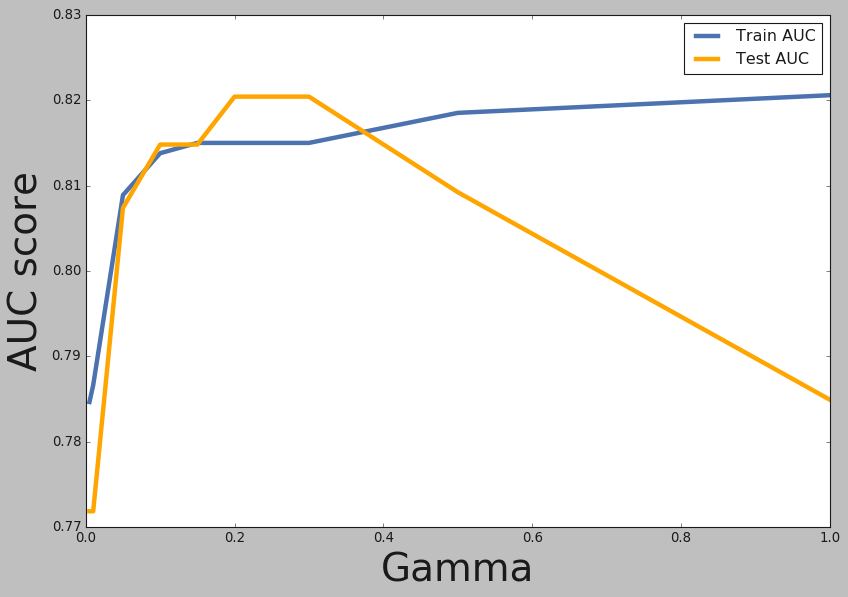

In [85]:
from matplotlib.legend_handler import HandlerLine2D
plt.style.use(['classic'])
fig, ax = plt.subplots(figsize=(12, 8))
line1, = plt.plot(Gamma, train_results, 'b', label="Train AUC", linewidth = 4)
line2, = plt.plot(Gamma, test_results, 'orange', label="Test AUC", linewidth = 4)
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score', fontsize = 35)
plt.xlabel('Gamma', fontsize = 35)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['font.size'] = 30
#plt.rc('xtick', labelsize=45)     
#plt.rc('ytick', labelsize=45)
plt.show()
fig.savefig('images/curve_ROC_gamma.png')

In [82]:
C_list = [1, 10, 20, 30, 40, 200, 300]
train_results = []
test_results = []
for c in C_list:
    model = SVC( C = c, kernel = 'rbf')
    model.fit(X_train_2, y_train)
    train_pred = model.predict(X_train_2)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_2)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
  

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

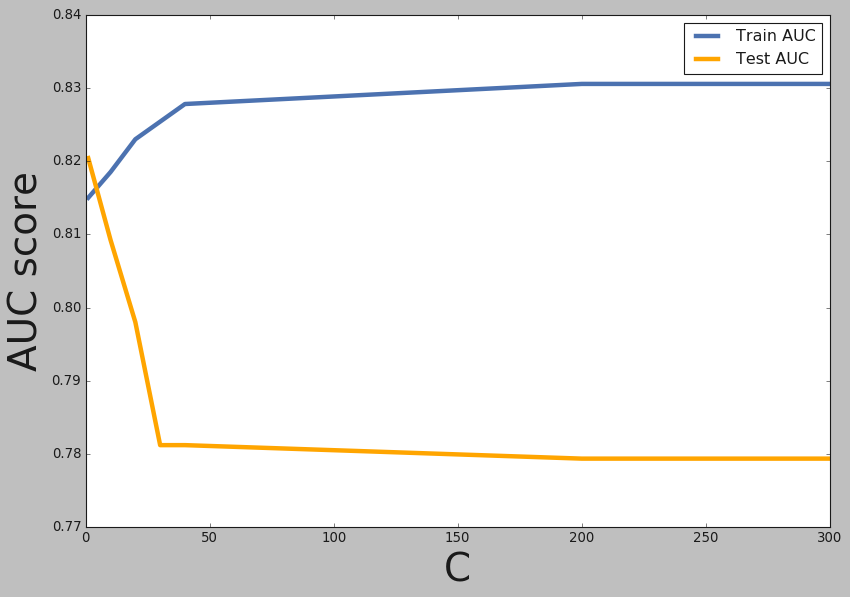

In [83]:
from matplotlib.legend_handler import HandlerLine2D
plt.style.use(['classic'])
fig, ax = plt.subplots(figsize=(12, 8))
line1, = plt.plot(C_list, train_results, 'b', label="Train AUC", linewidth = 4)
line2, = plt.plot(C_list, test_results, 'orange', label="Test AUC", linewidth = 4)
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score', fontsize = 35)
plt.xlabel('C', fontsize = 35)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['font.size'] = 30
#plt.rc('xtick', labelsize=45)     
#plt.rc('ytick', labelsize=45)
plt.show()
fig.savefig('images/curve_ROC_C.png')

In [114]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    "min_samples_split": np.linspace(0.1, 0.5, 4),
    "min_samples_leaf": np.linspace(0.1, 0.5, 4),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 1.0],
    "n_estimators":[10]
    }

clf = GridSearchCV(ensemble.GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

clf.fit(X_train_2, y_train)
print(clf.score(X_train_2, y_train))
print(clf.best_params_)


KeyboardInterrupt: 

In [77]:
learning_rates = [0.5, 0.25, 0.1, 0.05, 0.03, 0.02, 0.015, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    model = ensemble.GradientBoostingClassifier(learning_rate=eta)
    model.fit(X_train_2, y_train)
    train_pred = model.predict(X_train_2)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_2)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    

In [89]:
test_results

[0.8130135837665604,
 0.8260523226563811,
 0.7923444574878417,
 0.8035804125440215,
 0.8073117558276035,
 0.8073117558276035,
 0.8073117558276035,
 0.8073117558276035]

In [90]:
train_results

[0.9012381541978189,
 0.8826801276251249,
 0.8532787275584552,
 0.8313491118624697,
 0.8249869041382922,
 0.8218058002762036,
 0.8198295156912234,
 0.8170817657983714]

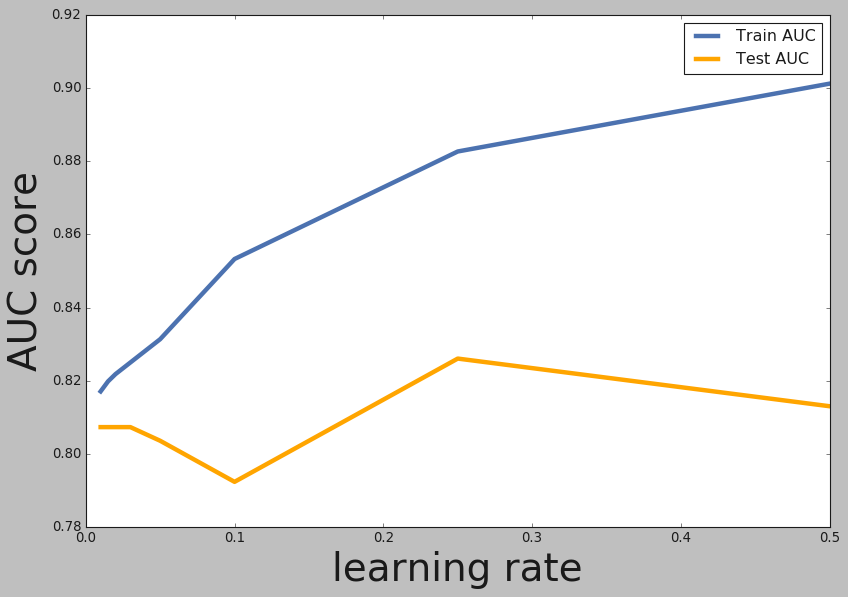

In [79]:
from matplotlib.legend_handler import HandlerLine2D
plt.style.use(['classic'])
fig, ax = plt.subplots(figsize=(12, 8))
line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC", linewidth = 4)
line2, = plt.plot(learning_rates, test_results, 'orange', label="Test AUC", linewidth = 4)
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score', fontsize = 35)
plt.xlabel('learning rate', fontsize = 35)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['font.size'] = 30
#plt.rc('xtick', labelsize=45)     
#plt.rc('ytick', labelsize=45)
plt.show()
fig.savefig('images/curve_ROC.png')

In [61]:
MLA = [ensemble.GradientBoostingClassifier(learning_rate= 0.5),
    ensemble.GradientBoostingClassifier(learning_rate=0.25),
    ensemble.GradientBoostingClassifier(learning_rate=0.1),
    ensemble.GradientBoostingClassifier(learning_rate=0.05),
    ensemble.GradientBoostingClassifier(learning_rate=0.03),
    ensemble.GradientBoostingClassifier(learning_rate=0.02),
    ensemble.GradientBoostingClassifier(learning_rate=0.015),
    ensemble.GradientBoostingClassifier(learning_rate=0.01)]

(MLA_compare, MLA_columns) = compare_model(X_train_2, X_test_2, y_train, y_test)
MLA_compare

,ML Name,ML Train Accuracy,ML Test Accuracy,ML Precission,ML Recall,ML AUC
0,GradientBoostingClassifier,0.9147,0.8206,0.775281,0.775281,0.813014
1,GradientBoostingClassifier,0.9012,0.8386,0.819277,0.764045,0.826052
2,GradientBoostingClassifier,0.8743,0.8117,0.805195,0.696629,0.792344
3,GradientBoostingClassifier,0.8518,0.8206,0.810127,0.719101,0.803580
4,GradientBoostingClassifier,0.8458,0.8251,0.820513,0.719101,0.807312
5,GradientBoostingClassifier,0.8428,0.8251,0.820513,0.719101,0.807312
6,GradientBoostingClassifier,0.8413,0.8251,0.820513,0.719101,0.807312
7,GradientBoostingClassifier,0.8398,0.8251,0.820513,0.719101,0.807312


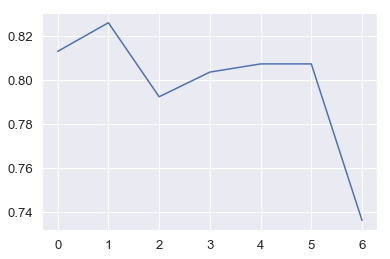

In [131]:
MLA_compare['ML AUC'].plot()

In [ ]:
def svc_param_selection(X_train, y_train, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X_train_35, y_train)
    grid_search.best_params_
    return grid_search.best_params_



In [ ]:
from scipy import stats
rand_list = {"C": stats.uniform(2, 100),
             "gamma": stats.uniform(0.01, 1)}
              
rand_search = RandomizedSearchCV(svm.SVC(kernel='rbf'), param_distributions = rand_list, cv = 10, random_state = 42) 
rand_search.fit(X_train_35, y_train)
rand_search.best_params_



In [ ]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [ ]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [5]:
x = [1, 2, 0]
y = bool(x)
y

True

In [2]:
y = bool(x)



In [7]:
t = list(map(bool,x))

In [8]:
t

[True, True, False]

In [12]:
import numpy as np

In [9]:
def merge_dictionnary(dict1, dict2):
    return dict(list(dict1.items()) + list(dict2.items()))

In [15]:
def precision(y_pred, y):
    true_positive = len(np.nonzero((y_pred == y) and (y_pred == 1))[0])
    false_positive = len(np.nonzero((y_pred != y) and (y_pred == 1))[0])
    precision = true_positive/(true_positive + false_positive)
    return precision
   

In [16]:
y_pred = np.array([1,0,1, 1])
y = np.array([1, 1, 0, 0])

In [17]:
precision(y_pred, y)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()